In [1]:
from pathlib import Path
import pydicom
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
labels = pd.read_csv("../input/rsnacardiacdetectionlabels/rsna_heart_detection.csv")
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [3]:
labels.shape

(496, 8)

In [4]:
ROOT_PATH = Path("../input/rsna-pneumonia-detection-challenge/stage_2_train_images")
SAVE_PATH = Path("./processed-cardiac-detection")

### Visualization

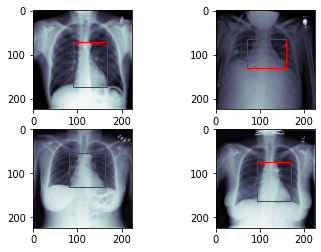

In [5]:
fig, axis = plt.subplots(2,2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)
        dcm_path = dcm_path.with_suffix(".dcm")
        
        dcm = pydicom.read_file(dcm_path)
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))
        
        x = data["x0"]
        y = data["y0"]
        w = data["w"]
        h = data["h"]
        
        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        axis[i][j].add_patch(rect)
        c+=1

### Preprocessing

In [6]:
sums, sums_squared = 0, 0
train_ids, val_ids = [],  []

for counter, patient_id in enumerate(list(labels.name)):
    
    dcm_path = ROOT_PATH/str(patient_id)
    dcm_path = dcm_path.with_suffix(".dcm")

    dcm = pydicom.read_file(dcm_path)
    dcm_array = dcm.pixel_array
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 225).astype(np.float16)
    
    train_or_val = "train" if counter < 400 else "val"
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
        
    current_save_path = SAVE_PATH/train_or_val
    current_save_path.mkdir(parents=True, exist_ok=True)
    
    np.save(current_save_path/patient_id, dcm_array)
    
    normalizer = 224 * 224
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array**2).sum() / normalizer   

In [7]:
np.save(SAVE_PATH/"train_subjects", train_ids)
np.save(SAVE_PATH/"val_subjects", val_ids)

In [8]:
mean = sums / len(train_ids)
std = np.sqrt((sums_squared / len(train_ids)) - mean**2)

mean, std

(0.5602303890306122, 0.2864769583861858)

### Dataset Class

In [9]:
import torch
import imgaug
from imgaug.augmentables.bbs import BoundingBox
import imgaug.augmenters as iaa

In [10]:
class CardiacDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient = self.patients[idx]
        data = self.labels[self.labels["name"] == patient]
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()
        y_max = y_min + data["h"].item()
        
        bbox = [x_min, y_min, x_max, y_max]
        
        file_path = self.root_path/patient
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        if self.augment:
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            
            img, aug_bbox = self.augment(image=img, bounding_boxes=bb)
            # x-top left, y-top left, x-bottom right, y-bottom right
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1] # top left & bottom right for bounding box
            
        img = (img - 0.560) / 0.286
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        return img, bbox

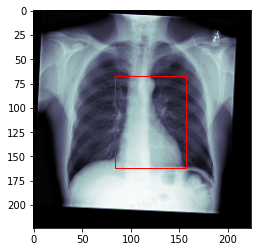

In [11]:
# augmentations
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
    scale=(0.8, 1.2),
    rotate=(-10, 10),
    translate_px=(-10, 10))
])

# paths
labels_path = "../input/rsnacardiacdetectionlabels/rsna_heart_detection.csv"
patients_path = "./processed-cardiac-detection/train_subjects.npy"
train_root = "./processed-cardiac-detection/train"

# dataset
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

# visualization
img, bbox = dataset[0]
fig, axis = plt.subplots(1,1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

### Data Loading

In [12]:
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [13]:
train_root = "./processed-cardiac-detection/train"
train_subjects = "./processed-cardiac-detection/train_subjects.npy"

val_root = "./processed-cardiac-detection/val"
val_subjects = "./processed-cardiac-detection/val_subjects.npy"

train_transforms = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10))
])

In [14]:
train_dataset = CardiacDataset("../input/rsnacardiacdetectionlabels/rsna_heart_detection.csv",
                              train_subjects, train_root, train_transforms)

val_dataset = CardiacDataset("../input/rsnacardiacdetectionlabels/rsna_heart_detection.csv",
                            val_subjects, val_root, None)

In [15]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Model Class

In [16]:
class CardiacDetectionModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            # mean=0.560, std=0.286
            img = ((x_ray[i] * 0.286)+ 0.560).numpy()[0]
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1,y1), (0, 0, 0), 2) # true bounding box
            
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1,y1), (1, 1, 1), 2) # pred bounding box
            
            results.append(torch.tensor(img).unsqueeze(0))
            
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [17]:
model = CardiacDetectionModel()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [18]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val Loss",
    save_top_k=10,
    mode="min"
)

In [19]:
accelerator = 'gpu'
devices = 1

In [20]:
trainer = pl.Trainer(accelerator=accelerator, devices=devices, logger=TensorBoardLogger("./Logs"), 
                     log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=50)

In [ ]:
trainer.fit(model, train_loader, val_loader)

In [33]:
ls "./Logs/lightning_logs/version_0/checkpoints/"

'epoch=39-step=2000.ckpt'  'epoch=44-step=2250.ckpt'  'epoch=48-step=2450.ckpt'
'epoch=40-step=2050.ckpt'  'epoch=45-step=2300.ckpt'  'epoch=49-step=2500.ckpt'
'epoch=42-step=2150.ckpt'  'epoch=46-step=2350.ckpt'
'epoch=43-step=2200.ckpt'  'epoch=47-step=2400.ckpt'


In [35]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
model = model.load_from_checkpoint("./Logs/lightning_logs/version_0/checkpoints/epoch=49-step=2500.ckpt")
model.eval()
model.to(device)

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [44]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds = torch.stack(preds)
labels = torch.stack(labels)

In [45]:
abs(preds-labels).mean(0)

tensor([ 9.1236,  7.7240, 10.6524,  9.1833])

tensor([ 97,  60, 176, 149])


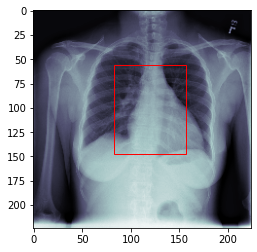

In [52]:
IDX = 20
img, label = val_dataset[IDX]
pred = preds[IDX]

fig, axis = plt.subplots(1,1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]- pred[1], 
                          linewidth=1, edgecolor="r", facecolor="none")
axis.add_patch(heart)
print(label)